<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a href="https://agrum.gitlab.io/pages/pyagrum.html" target="blank"><img src="https://agrum.gitlab.io/images/pyAgrum.png" align="right" style="height:75px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a><br/>
Author: <b>Aymen Merrouche</b> and Pierre-Henri Wuillemin.

<font size="+3" color="GREEN">**Where is my Bag ?**</font>

#### This notebook follows the example from "The Book Of Why" (Pearl, 2018) chapter 3 page 115. 

In [1]:
from IPython.display import display, Math, Latex,HTML

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import matplotlib.pyplot as plt
import seaborn as sns

>After making a stopover, a passenger is waiting for his luggage. What are the chances that his luggage wasn't properly routed and got lost? 
The appearance of his luggage on the carousel has two causes, its presence on the plane (if not, then there are no chances for him to recover it) and the time he spent waiting in front of the carousel. (The more he waits, the more his chances of seeing his luggage increase.)

## We create the causal diagram :
The corresponding causal diagram is the following:

In [2]:
ab = gum.fastBN('Elapsed time[11]->Bag on Carousel<-Bag on Plane')
ab

(pyAgrum.BayesNet<double>@0x559949ad0ee0) BN{nodes: 3, arcs: 2, domainSize: 44, dim: 33, mem: 456o}

In [3]:
# We fill the CPTs
ab.cpt("Bag on Plane").fillWith(1).normalize()
ab.cpt("Elapsed time").fillWith(1).normalize()
ab.cpt("Bag on Carousel").fillWith([1.0,0.0]*11+[1-i/20 if i%2==0 else (i-1)/20 for i in range(22)])

(pyAgrum.Potential<double>@0x559949a7eb20) 
             ||  Bag on Carousel  |
Elapse|Bag on||0        |1        |
------|------||---------|---------|
0     |0     || 1.0000  | 0.0000  |
1     |0     || 1.0000  | 0.0000  |
2     |0     || 1.0000  | 0.0000  |
3     |0     || 1.0000  | 0.0000  |
4     |0     || 1.0000  | 0.0000  |
5     |0     || 1.0000  | 0.0000  |
[...10 more line(s) ...]
5     |1     || 0.5000  | 0.5000  |
6     |1     || 0.4000  | 0.6000  |
7     |1     || 0.3000  | 0.7000  |
8     |1     || 0.2000  | 0.8000  |
9     |1     || 0.1000  | 0.9000  |
10    |1     || 0.0000  | 1.0000  |

In [4]:
gnb.sideBySide(ab,ab.cpt("Bag on Plane"),
               ab.cpt("Elapsed time"),
               captions=["the BN","marginal for $BagOnPlane$","marginal for $Elapsed time$"])

### It is obvious that: <br>
* If the bag is on the plane, you will receive it within the 10 minutes:
$$P(BagOnCarousel = True \mid ElapsedTime = 10,BagOnPlane = True) = 1$$ 

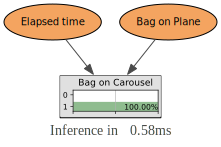

In [5]:
# Knowing that 'Bag on Plane':1 and 'Elapsed time': 10
gnb.showInference(ab,targets={"Bag on Carousel"},evs={'Bag on Plane':1,'Elapsed time': 10})

* If the bag is not on the plane in the first place, there are no chances of receiving it :
$$P(BagOnCarousel = False \mid BagOnplane = False) = 1$$

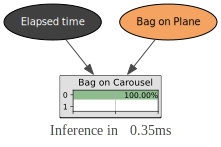

In [6]:
# Knowing that 'Bag on Plane':0
gnb.showInference(ab,targets={"Bag on Carousel"},evs={'Bag on Plane':0})

## If $x$ minutes have passed and I still haven't gotten my bag, what is the probability that it was on the plane (that I will eventually receive it)?

> We are interested in probability: $$P(Bag On plane = true \mid ElapsedTime = x,BagOnCarousel = False)$$
In other words, you are waiting by the carousel at the airport, $x$ minutes have passed and you still haven't received your bag what's the probability that you'll eventually receive it ?. We're looking for the probability that you'll eventually receive your bag (i.e. your bag being on the plane as we saw above.) given that $x$ minutes have passed.

In [7]:
# inference engine : LazyPropagation
ie1 = gum.LazyPropagation(ab) 
ie1.setEvidence({"Elapsed time" : 0,"Bag on Carousel" : 0})
time = {}
# For every value of elapsed time
for t in range(0,11):
    # We get the probability of eventually receiving the bag
    ie1.chgEvidence("Elapsed time",t)
    ie1.makeInference()
    time[t]=ie1.posterior("Bag on Plane")[1]
# time is a dictionary : for x in [0,10] {x minutes : P(Bag On plane = true | ElapsedTime = x minutes,BagOnCarousel = False)}

### The curve of Abandoning Hope:

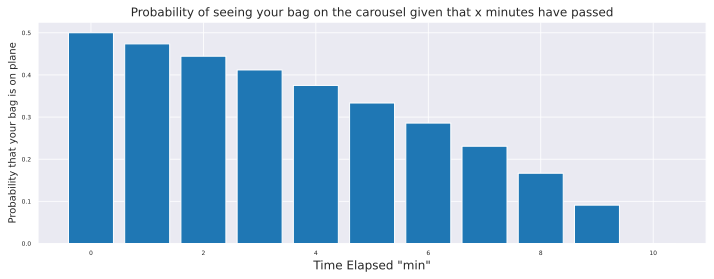

In [8]:
# plot style
sns.set_style('darkgrid')
# labels size
plt.rc('xtick', labelsize = 6)
plt.rc('ytick', labelsize = 6)
#figure size
plt.figure(figsize=(12,4))
plt.xlabel('Time Elapsed "min"', fontsize = 12)
plt.ylabel('Probability that your bag is on plane', fontsize=10)
#title
plt.title('Probability of seeing your bag on the carousel given that x minutes have passed', fontsize=12)
plt.bar(time.keys(), time.values())
plt.show()

> After waiting half of the total time, don't panic, <b>There is still a probability of 33% that you will receive your luggage. (with a 50% probability, in the beginning, $\implies$ you should only lose one-third of your hope)</b> !
$$P(Bag On plane = True \mid ElapsedTime = 5,BagOnCarousel = False) = 0.33$$

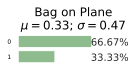

In [9]:
gnb.showPosterior(ab,target="Bag on Plane",evs={"Elapsed time" : 5,"Bag on Carousel" : 0})

## Concerning Colliders : 

In the junction $BagOnPlane \rightarrow BagOnCarousel \leftarrow ElpasedTime$, the node $BagOnCarousel$ is called a collider  (where two or more arrowheads meet). This junction is not an open path $\implies$ no back-door paths between "Bag On Plane" and "Elapsed Time". We don't need to account for "Bag On Carousel" to assess the causal effect of "Bag On plane" on "Elapsed Time". The two variables "Time Elapsed" and "Bag On plane" are <b>d-separate</b>, they are independent, however, they both are causes of "Bag On Carousel" <br>
### We don't need to account for anything to assess the causal effect of "Bag On plane" on "Elapsed Time" :

In [10]:
abModele = csl.CausalModel(ab)
cslnb.showCausalImpact(abModele,"Elapsed time",doing="Bag on Plane",values={})

### Collider bias!
Although a little bit counter-intuitive, conditioning on "Bag On Carousel" will make the two variables dependent! <b>Adjusting for a collider increases bias </b>
> If the bag is not on the carousel and 9 minutes have passed, then it is more likely that the bag is not on the plane.

<img src="images/figure.3.5.png" alt="Collider Bias" style="width: 500px;"/>

> To illustrate collider bias, we will assess the causal effect of "Elapsed Time" on "Bag On Plane" when we don't adjust for collider "Bag On Carousel" and when we adjust for it. (for example, look only in the case where "Bag on Carousel" = 0)

### Without adjusting for collider "Bag On Carousel" :

In [11]:
abModele = csl.CausalModel(ab)
cslnb.showCausalImpact(abModele,on={"Bag on Plane"},doing={"Elapsed time"},values={"Elapsed time" : 9})

> The two variables are independent.

### When adjusting for collider "Bag On Carousel" :

<b> If we observe that the bag is not on the carousel (Bag On Carousel = 0), the more time passes the more likely the luggage is not on the plane. </b>

In [12]:
abModele = csl.CausalModel(ab)
cslnb.showCausalImpact(abModele,on={"Bag on Plane"},doing={"Elapsed time"},knowing={"Bag on Carousel"},values={"Elapsed time" : 7,"Bag on Carousel": 0})

> The two variables become dependent.
#### We can draw a curve of the effect of "Elapsed Time" on "Bag on Plane" when adjusting for "Bag On Carousel" (=0) :

In [13]:
formula, impact, explanation = csl.causalImpact(abModele, on={"Bag on Plane"}, doing={"Elapsed time"}, knowing={"Bag on Carousel"})
formula

> As we saw previously, if you still didn't receive your bag, the more you wait the more likely your bag is not on the plane.

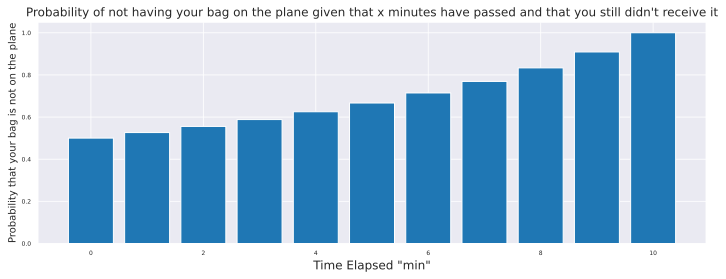

In [14]:
#style du plot
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 6)
plt.rc('ytick', labelsize = 6)
#taille de la figure
plt.figure(figsize=(12,4))
plt.xlabel('Time Elapsed "min"', fontsize = 12)
plt.ylabel('Probability that your bag is not on the plane', fontsize=10)
#titre
plt.title('Probability of not having your bag on the plane given that x minutes have passed and that you still didn\'t receive it', fontsize=12)
plt.bar(range(11),impact.extract({"Bag on Carousel": 0,"Bag on Plane":0}).tolist())
plt.show()